# Westeros multinode tutorial: Adding DACCS in climate mitigation scenario
In the previous tutorials, we have learnt how to create a baseline scenario (`westeros_baseline.ipynb`) and add emissions bounds (`westeros_emissions_bounds.ipynb`) to the baseline scenario. Here, we will show how to include an additional/new technology to a MESSAGE model. While the combination of currently existing technologies might be able to deliver the Paris targets, the deployment of some new technologies might improve the probability of meeting the targets and/or reducing the costs. These technologies include CO2 removal (CDR) technologies. Hence, in this tutorial, we will use direct air carbon capture and storage (DACCS) as an example of new technologies to be considered in climate mitigation pathways. 

In order to smoothly follow this tutorial, you have to alrady have the MESSAGEix framework installed and working. Additionally, you should have run the Westeros baseline and emissions bounds scenarios successfully as this tutorial is built on top of those scenarios.

If all set, we can start by importing all the packages we need and connect to a database that store the scenario input and results. We can also name the model as `Westeros Electrified` here.

In this tutorial, we will use add_dac tool which requires user to specify the location of the data, in yaml format. As such, we use os package to help us specifying the yaml file.

In [1]:
import os

import pandas as pd
import ixmp
import message_ix
import warnings
warnings.filterwarnings('ignore')

from message_ix.utils import make_df
from message_ix.tools.add_tech import add_tech



%matplotlib inline

mp = ixmp.Platform()

model = "Westeros Electrified"

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


After we are connected to the database, we can call the prevously run `"emission_bound"` scenario as our base model and clone the data before we start adding DACCS to the model. As prevoiusly mentioned, to run this tutorial, you have to have succesfully run the `"emission_bound"` scenario, which was built based on the `"baseline"` scenario.

In [2]:
base = message_ix.Scenario(mp, model=model, scenario="multinode_hub")

scenario = base.clone(
    model,
    "multinode_hub_emission_bound",
    "multinode_hub with emission bound",
    keep_solution=False,)
scenario.check_out()

year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scenario.set("year")
regions = scenario.set("node")#["Westeros", "Essos", "Stepstones"]

In [3]:
# add "World" node
scenario.add_set("node","World")

# add "WorldEmiss" technology
scenario.add_set("technology","WorldEmiss")

# add "CO2" commodity
scenario.add_set("commodity","CO2")


In [4]:
# add emission factor
# First we introduce the emission of CO2 and the emission category GHG
scenario.add_set("emission", "CO2")
scenario.add_set("emission", "CO2world")
scenario.add_cat("emission", "GHG", "CO2")
scenario.add_cat("emission", "GHGworld", "CO2world")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

model_years = sorted(list(set(act_years)))

# Last we add CO2 emissions to the coal powerplant
for reg in regions:
    if reg not in ["World","hub"]:
        emission_factor = make_df(
            "emission_factor",
            node_loc=reg,
            year_vtg=vintage_years,
            year_act=act_years,
            mode="standard",
            unit="tCO2/kWa",
            technology="coal_ppl",
            emission="CO2",
            value=7.4,
        )
        scenario.add_par("emission_factor", emission_factor)

# Last we add CO2 emissions to the WorldEmiss
emission_factor = make_df(
    "emission_factor",
    node_loc="World",
    year_vtg=model_years,
    year_act=model_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="WorldEmiss",
    emission="CO2world",
    value=1,
)
scenario.add_par("emission_factor", emission_factor)

In [5]:
# adding emission output
# Parametrization of "output" for import technologies
# The destination of import is the level of "secondary" in each country
base_output = {
    "technology": "WorldEmiss",
    "commodity": "CO2",
    "level": "secondary",
    "year_vtg": model_years,
    "year_act": model_years,
    "mode": "standard",
    "time": "year",
    "time_dest": "year",
    "value": 1,
    "unit": "-",
}

# We add this data for each node (other than "hub")
out = make_df("output", **base_output, node_loc="World", node_dest="World")
scenario.add_par("output", out)

In [6]:
# add "CO2_Emission_World_Accounting" to relation set
scenario.add_set("relation","CO2_Emission_World_Accounting")

# add relation, relating coal activity with WorldEmiss activity
emission_relation = []
# for coal
for reg in regions:
    emission_relation.append(
        make_df(
            "relation_activity",
            relation="CO2_Emission_World_Accounting",
            node_rel="World",
            year_rel=model_years,
            node_loc=reg,
            technology="coal_ppl",
            year_act=model_years,
            mode="standard",
            value=7.2, # this represents capacity factor of coal_ppl
            unit="-",
        )
    )

# for WorldEmiss
emission_relation.append(
    make_df(
        "relation_activity",
        relation="CO2_Emission_World_Accounting",
        node_rel="World",
        year_rel=model_years,
        node_loc="World",
        technology="WorldEmiss",
        year_act=model_years,
        mode="standard",
        value=-1, # this has negative signs so sum of emission from each regions and world is equal to 0
        unit="-",
    )
)
emission_relation = pd.concat(emission_relation)
# Adding the dataframe to the scenario
scenario.add_par("relation_activity", emission_relation)


# don't forget to include relation upper and lower to 0
# relation lower and upper bounds
rel_lower_upper = []
for rel in ["CO2_Emission_World_Accounting"]:
    for reg in regions:
        rel_lower_upper.append(
            make_df(
                "relation_lower",
                relation=rel,
                node_rel=reg,
                year_rel=model_years,
                value=0,
                unit="-",
            )
       )
rel_lower_upper = pd.concat(rel_lower_upper)

# Adding the dataframe to the scenario
scenario.add_par("relation_lower", rel_lower_upper)
scenario.add_par("relation_upper", rel_lower_upper)



In [7]:
# removing some parameters
pars2remove = ['relation_activity']
for par in pars2remove:
    df = scenario.par(par,{'technology':'coal_ppl','node_loc':['World','hub']})
    scenario.remove_par(par, df)

In [8]:
scenario.par("relation_activity")

,relation,node_rel,year_rel,node_loc,technology,year_act,mode,value,unit
0,CO2_Emission_World_Accounting,World,700,Westeros,coal_ppl,700,standard,7.2,-
1,CO2_Emission_World_Accounting,World,710,Westeros,coal_ppl,710,standard,7.2,-
2,CO2_Emission_World_Accounting,World,720,Westeros,coal_ppl,720,standard,7.2,-
3,CO2_Emission_World_Accounting,World,700,Essos,coal_ppl,700,standard,7.2,-
4,CO2_Emission_World_Accounting,World,710,Essos,coal_ppl,710,standard,7.2,-
5,CO2_Emission_World_Accounting,World,720,Essos,coal_ppl,720,standard,7.2,-
6,CO2_Emission_World_Accounting,World,700,Stepstones,coal_ppl,700,standard,7.2,-
7,CO2_Emission_World_Accounting,World,710,Stepstones,coal_ppl,710,standard,7.2,-
8,CO2_Emission_World_Accounting,World,720,Stepstones,coal_ppl,720,standard,7.2,-
9,CO2_Emission_World_Accounting,World,700,World,WorldEmiss,700,standard,-1.0,-


In [9]:
# add emission bound
scenario.add_par(
    "bound_emission", ["World", "GHGworld", "all", "cumulative"], value=1500.0, unit="MtCO2"
)

**Solve scenario without DACCS**

In [10]:
scenario.commit(comment="Multinode scenario emission bound without daccs")
scenario.set_as_default()

scenario.solve()
scenario.var("OBJ")["lvl"]

print('Objective value: ', scenario.var("OBJ")["lvl"])

Objective value:  479549.0625


**Comparing results**

**--- Without emissions limit:**

In [11]:
base.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,166.445336,0.0
1,Westeros,light,useful,710,year,162.039539,0.0
2,Westeros,light,useful,720,year,161.002627,0.0
3,Essos,light,useful,700,year,166.445336,0.0
4,Essos,light,useful,710,year,162.039539,0.0
5,Essos,light,useful,720,year,161.002627,0.0
6,Stepstones,light,useful,700,year,161.402965,0.0
7,Stepstones,light,useful,710,year,162.039539,0.0
8,Stepstones,light,useful,720,year,161.002627,0.0


**--- With emissions limit:**

In [12]:
scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,266.349390,0.0
1,Westeros,light,useful,710,year,317.023518,0.0
2,Westeros,light,useful,720,year,413.455198,0.0
3,Essos,light,useful,700,year,266.349390,0.0
4,Essos,light,useful,710,year,317.023518,0.0
5,Essos,light,useful,720,year,413.455198,0.0
6,Stepstones,light,useful,700,year,256.549684,0.0
7,Stepstones,light,useful,710,year,317.023518,0.0
8,Stepstones,light,useful,720,year,413.455198,0.0


# Adding DACCS description
First step of adding DACCS as a technology in the model is by including DACCS into the `"technology"` set.

In [13]:
dac_scenario = scenario.clone(
    model,
    "multinode_hub_emission_bound_dac",
    "multinode_hub with emission bound and dac",
    keep_solution=False,)
dac_scenario.check_out()

In [14]:
mp.add_unit("USD/(tCO2/yr)")
mp.add_unit("USD/(tCO2/yr)/yr")
mp.add_unit("USD/tCO2")
mp.add_unit("tCO2/tCO2")
mp.add_unit("tCO2")
mp.add_unit("Mt CO2/yr")


filepath = os.path.join(os.getcwd(), "data/tech_data_multinode.yaml")
add_tech(dac_scenario, filepath=filepath)

# removing some parameters
pars2remove = ['relation_activity']
for par in pars2remove:
    df = dac_scenario.par(par,{'technology':'daccs','node_loc':['World','hub']})
    dac_scenario.remove_par(par, df)
    
    df = dac_scenario.par(par)
    df= df.loc[df['node_rel'] != "World"]
    dac_scenario.remove_par(par, df)

In [15]:
dac_scenario.par("relation_activity")

,relation,node_rel,year_rel,node_loc,technology,year_act,mode,value,unit
0,CO2_Emission_World_Accounting,World,700,Westeros,coal_ppl,700,standard,7.2,-
1,CO2_Emission_World_Accounting,World,710,Westeros,coal_ppl,710,standard,7.2,-
2,CO2_Emission_World_Accounting,World,720,Westeros,coal_ppl,720,standard,7.2,-
3,CO2_Emission_World_Accounting,World,700,Essos,coal_ppl,700,standard,7.2,-
4,CO2_Emission_World_Accounting,World,710,Essos,coal_ppl,710,standard,7.2,-
5,CO2_Emission_World_Accounting,World,720,Essos,coal_ppl,720,standard,7.2,-
6,CO2_Emission_World_Accounting,World,700,Stepstones,coal_ppl,700,standard,7.2,-
7,CO2_Emission_World_Accounting,World,710,Stepstones,coal_ppl,710,standard,7.2,-
8,CO2_Emission_World_Accounting,World,720,Stepstones,coal_ppl,720,standard,7.2,-
9,CO2_Emission_World_Accounting,World,700,World,WorldEmiss,700,standard,-1.0,-


Similar to what we did when generating the `"baseline"` scenario, the first thing we need to do is defining the input and output comodities of each technology. 

# Solve Statement
Finally, this is the solve statement

In [16]:
dac_scenario.commit(comment="Adding daccs using add_dac tool")
dac_scenario.set_as_default()

dac_scenario.solve()
dac_scenario.var("OBJ")["lvl"]

print('Objective Value')
print('Without DACCS: ', scenario.var("OBJ")["lvl"])
print('With DACCS   : ', dac_scenario.var("OBJ")["lvl"])

Objective Value
Without DACCS:  479549.0625
With DACCS   :  465498.90625


# Plotting Results and Compare
Finally, this is the plotting results command to compare emissions bound scenarios with and without DACCS

In [17]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep_ori = Reporter.from_scenario(scenario)
rep_new = Reporter.from_scenario(dac_scenario)

## System acticity

Without DACCS


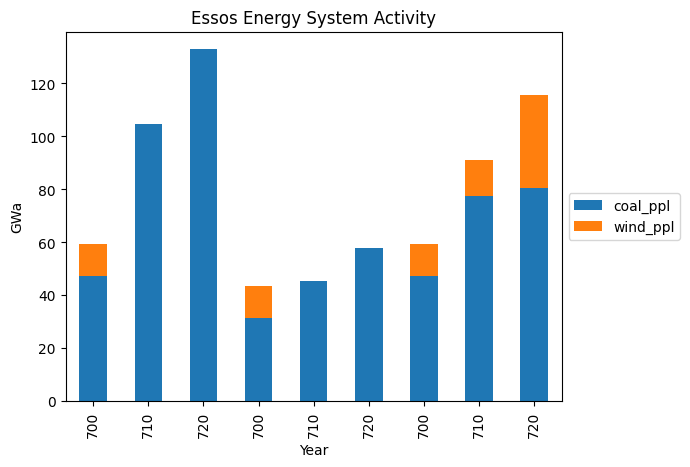

With DACCS


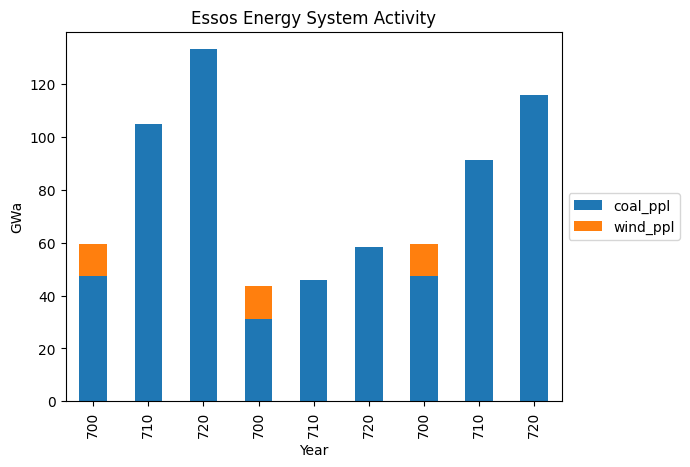

In [18]:
print("Without DACCS")
prepare_plots(rep_ori)
rep_ori.set_filters(t=["coal_ppl", "wind_ppl"])
rep_ori.get("plot activity")
plt.show()

print("With DACCS")
prepare_plots(rep_new)
rep_new.set_filters(t=["coal_ppl", "wind_ppl"])
rep_new.get("plot activity")
plt.show()

## DACCS Capacity

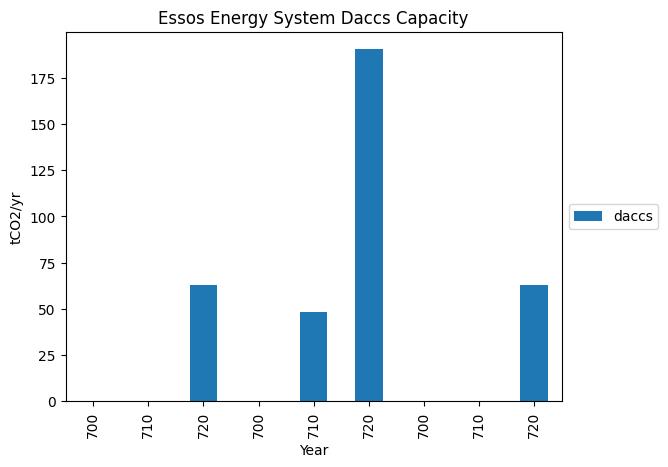

In [19]:
prepare_plots(rep_new)
rep_new.set_filters(t=["daccs"])
rep_new.get("plot daccs capacity")
plt.show()

## Emissions

Without DACCS


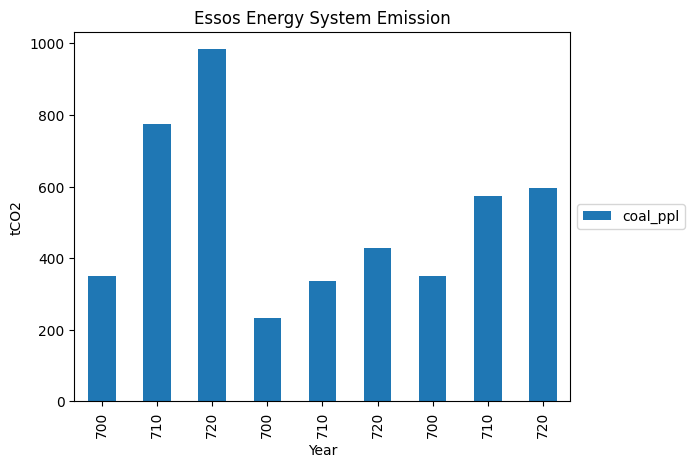

emission_factor: mixed units ['tCO2/kWa', 'tCO2/tCO2'] discarded


With DACCS


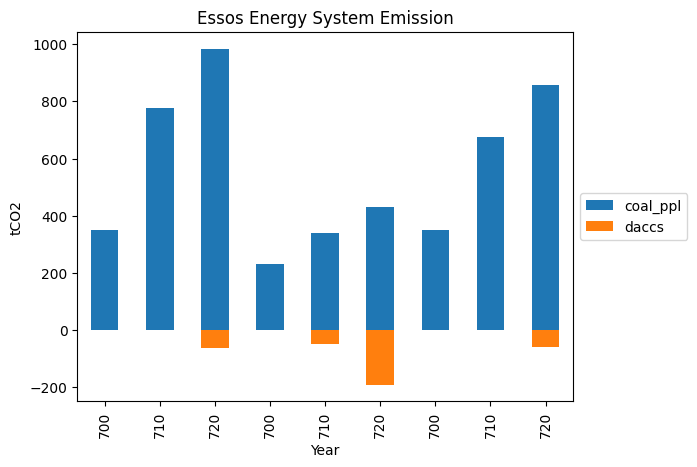

In [20]:
print("Without DACCS")
prepare_plots(rep_ori)
rep_ori.set_filters(t=["coal_ppl", "wind_ppl"])
rep_ori.get("plot emission")
plt.show()

print("With DACCS")
prepare_plots(rep_new)
rep_new.set_filters(t=["coal_ppl", "wind_ppl","daccs"])
rep_new.get("plot emission")
plt.show()

**Comparing prices**

**--- Without DACCS:**

In [21]:
scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,266.349390,0.0
1,Westeros,light,useful,710,year,317.023518,0.0
2,Westeros,light,useful,720,year,413.455198,0.0
3,Essos,light,useful,700,year,266.349390,0.0
4,Essos,light,useful,710,year,317.023518,0.0
5,Essos,light,useful,720,year,413.455198,0.0
6,Stepstones,light,useful,700,year,256.549684,0.0
7,Stepstones,light,useful,710,year,317.023518,0.0
8,Stepstones,light,useful,720,year,413.455198,0.0


**--- With DACCS:**

In [22]:
dac_scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,226.890658,0.0
1,Westeros,light,useful,710,year,255.810073,0.0
2,Westeros,light,useful,720,year,313.744947,0.0
3,Essos,light,useful,700,year,226.890658,0.0
4,Essos,light,useful,710,year,255.810073,0.0
5,Essos,light,useful,720,year,313.744947,0.0
6,Stepstones,light,useful,700,year,218.969939,0.0
7,Stepstones,light,useful,710,year,255.810073,0.0
8,Stepstones,light,useful,720,year,313.744947,0.0


## Close the connection with the database

In [23]:
mp.close_db()